In [16]:
%matplotlib inline
from fgspectra import cross as fgc
from fgspectra import power as fgp
from fgspectra import frequency as fgf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import sensitivity_calculator as sens
from so_models_v3 import SO_Noise_Calculator_Public_v3_1_1 as SO_noise
import emcee
from multiprocessing import Pool
import corner
import tqdm
import os

#helper functions
dcolors = [
    '#e41a1c',  # red
    '#4daf4a',  # green
    '#984ea3',  # purple
    '#ff7f00',  # orange
    '#a65628',  # brown
    '#f781bf',  # pink
    '#66c2a5',  # teal
    '#4b0082',  # indigo
    '#2e8b57',  # sea green
    '#800000',  # maroon
    '#3b3b98',  # dark indigo
    '#5d3fd3',  # dark violet
]

#FTS resolution generator
def fts_res(centers, f = 1000):
    del_f =1.000
    ratio = del_f/f
    res = ratio * centers
    return np.round(res, 4)

def get_hivon_fsky(mask):
    npix = len(mask)
    non0 = np.where(mask!=0)[0]
    fs = len(non0)/float(npix)
    w2 = np.sum(mask[non0]**2)/(npix*fs)
    w4 = np.sum(mask[non0]**4)/(npix*fs)
    return fs*w2**2/w4

###############################
#range for power spectra
ells = np.arange(200, 8001)

#band centers
#from pcl_actpol_utility
def read_binfile(path, lmin=np.min(ells), lmax=np.max(ells)):
    lbands = np.genfromtxt(path)[:, :2].astype(int)

    # Filter only bins whose entire range is inside [lmin, lmax)
    mask = (lbands[:, 0] >= lmin) & (lbands[:, 1] <= lmax)
    lbands = lbands[mask]

    # Force first bin start ≥ 2
    if len(lbands) > 0 and lbands[0, 0] < 2:
        lbands[0, 0] = 2

    return lbands

def get_lbands_all(lbands, lmin=np.min(ells), lmax=np.max(ells)):
    nbins = len(lbands)

    ell = np.arange(lmin, lmax + 1)
    dl = ell * (ell + 1) / (2 * np.pi)

    band = np.zeros(nbins)
    ell_bin = np.zeros(nbins)

    for i in range(nbins):
        band[i] = (lbands[i, 1] - lbands[i, 0]) / 2.0
        ell_bin[i] = (lbands[i, 0] + lbands[i, 1]) / 2.0

    return ell_bin, band, nbins, lmax, ell, dl

#bin file should have no suffix and be in the same folder
lbands = read_binfile('BIN_ACTPOL_50_4_SC_low_ell', lmin=np.min(ells), lmax=np.max(ells)) #bin limits in l
(ell_bin, band, n_bins, lmax, elxx, dxx) = get_lbands_all(lbands,lmin=np.min(ells), lmax=np.max(ells))
#ell_bin = bin centers, band = bandwidth/2

##############################################################################333###############
#labels corresponding to the output fg spectra of the below get_fg_model
spectra_labels_full = ['kSZ','p','tSZ_CIB','s','g','tSZ','c']
#######################################################################
fore_indices = [1,6]
########################################################################
spectra_labels = [spectra_labels_full[i] for i in fore_indices]
n_fore = len(fore_indices)

var_groups = [
    ["a_kSZ"],
    ["a_p", "beta_p"],
    ["xi"],
    ["a_s"],
    ["a_g"],
    ["a_tSZ"],
    ["a_c", "beta_c"],
]
var_par_fid_original = {
    "a_kSZ": 1.60,
    "a_p": 6.90,  "beta_p": 2.20,
    "xi": 0.1,
    "a_s": 3.10,
    "a_g": 2.80,
    "a_tSZ": 3.30,
    "a_c": 4.90,  "beta_c": 2.20,
}
var_keys = [k for i in fore_indices for k in var_groups[i]]
var_par_fid = {k: var_par_fid_original[k] for k in var_keys}
fixed_par = {k: v for k, v in var_par_fid_original.items() if k not in var_keys}
fixed_par |= {
    "nu_0": 150.0,
    "ell_0": 3000,
    "T_CMB": 2.725,
    "T_d": 9.6,
    "n_CIBC": 1.20,
}
n_var = len(var_par_fid)

par_label_fg_groups = [
    [r"$a_{\mathrm{kSZ}}$"],        # kSZ amplitude
    [r"$a_p$", r"$\beta_p$"],        # Poisson CIB amplitude, Poisson CIB spectral index
    [r"$\xi_{\mathrm{tSZ}\times\mathrm{CIB}}$"],   # tSZ × CIB correlation
    [r"$a_s$"],             # Radio sources amplitude
    [r"$a_g$"],        # Galactic cirrus amplitude
    [r"$a_{\mathrm{tSZ}}$"],        # tSZ amplitude
    [r"$a_c$", r"$\beta_c$"],       # Clustered CIB amplitude, Clustered CIB spectral index
]
par_labels_fg = [label for i in fore_indices for label in par_label_fg_groups[i]]

# define the models from fgspectra
ksz = fgc.FactorizedCrossSpectrum(fgf.ConstantSED(), fgp.kSZ_bat())
cibp = fgc.FactorizedCrossSpectrum(fgf.ModifiedBlackBody(), fgp.PowerLaw())
radio = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())
cirrus = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())
# if there are correlations between components,
# have to define them in a joined spectrum
tSZ_and_CIB = fgc.CorrelatedFactorizedCrossSpectrum(
    fgf.Join(fgf.ThermalSZ(), fgf.CIB()), fgp.SZxCIB_Addison2012()
)
# for testing purposes we'll also compute the tSZ and clustered CIB alone
tsz = fgc.FactorizedCrossSpectrum(fgf.ThermalSZ(), fgp.tSZ_150_bat())
cibc = fgc.FactorizedCrossSpectrum(fgf.CIB(), fgp.PowerLaw())

#use this function to get spectra (auto and cross [f1,f2] for a given set of params)
def get_fg_model(freqs, ells, par):
    return (
        par["a_kSZ"] * ksz({"nu": freqs}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_p"]
        * cibp(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_p"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        # joint tSZ, CIB, and their correlation
        tSZ_and_CIB(
            {
                "kwseq": (
                    {"nu": freqs, "nu_0": par["nu_0"]},
                    {
                        "nu": freqs,
                        "nu_0": par["nu_0"],
                        "temp": par["T_d"],
                        "beta": par["beta_c"],
                    },
                )
            },
            {
                "kwseq": (
                    {"ell": ells, "ell_0": par["ell_0"], "amp": par["a_tSZ"]},
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "alpha": 2 - par["n_CIBC"],
                        "amp": par["a_c"],
                    },
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "amp": -par["xi"] * np.sqrt(par["a_tSZ"] * par["a_c"]),
                    },
                )
            },
        ),
        par["a_s"]
        * radio(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": -0.5 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        par["a_g"]
        * cirrus(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": 3.8 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": -0.7},
        ),
        # THESE TWO ARE REDUDUNDANT, BUT USEFUL FOR TESTING
        par["a_tSZ"]
        * tsz({"nu": freqs, "nu_0": par["nu_0"]}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_c"]
        * cibc(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_c"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2 - par["n_CIBC"]},
        ),
    )

#####################################################################################################
#CCAT noise curves
def get_ccat_noise():
    #get sky fraction fsky
    NSIDE = 1024                        #mask_share/ccat_uniform_coverage_nside1024_201021.fits
    hitm = hp.read_map(os.path.expanduser(f"mask_share/ccat_uniform_coverage_nside{NSIDE}_201021.fits"))
    maskm = hp.read_map(os.path.expanduser(f"mask_share/nside{NSIDE}_lat_cut_b10_230619.fits"))
    #hp.mollview(hitm*maskm) #plot sky map
    #hp.mollview(maskm)
    #ccat_fsky = np.sum(hitm*maskm)/len(hitm) #alternate method
    #print('fsky=%.4f'%fsky)
    
    ccat_fsky = get_hivon_fsky(hitm*maskm)
    inputs = {'diameter': 5.7, 't': 273, 'wfe': 10.7, 'eta': 0.98, 'doe': 0.8, 't_int': 1, 'pixelYield': 0.8, 
            'szCamNumPoln': 1, 'eorSpecNumPoln': 2, 't_filter_cold': np.array([0.593, 0.84 , 0.86, 0.86, 0.89 ]), 
            't_lens_cold': np.array([0.98, 0.98, 0.98, 0.98, 0.98]), 
            't_uhdpe_window': np.array([0.96, 0.97, 0.97, 0.97, 0.97]), 
            'singleModedAOmegaLambda2': np.array([1., 1., 1., 1., 1.]), 
            'spatialPixels': np.array([39762, 20808, 10368, 10368,  7938]), 
            'eqbw': np.array([9.7e+10, 3.0e+10, 3.5e+10, 6.0e+10, 5.6e+10]), 
            'centerFrequency': np.array([8.50e+11, 4.10e+11, 3.50e+11, 2.80e+11, 2.20e+11]), 'detectorNEP': 0, 
            'backgroundSubtractionDegradationFactor': 1, 'r': np.array([[100., 100., 100.],
                                                [100., 100., 100.],
                                                [100., 100., 100.],
                                                [100., 100., 100.],
                                                [100., 100., 100.]]), 
            'decimalPlaces': 3, 'observationElevationAngle': 45, 'outputFreq': True, 
            'detectorSpacing': np.array([1.45, 1.97, 2.75, 2.75, 3.13]), 'lyotStopAngle': 13.4}
    spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=True)
    calculate = sens.calcByAngle(inputs["diameter"], inputs["t"], inputs["wfe"], inputs["eta"], inputs["doe"], inputs["t_int"], inputs["pixelYield"], inputs["szCamNumPoln"], inputs["eorSpecNumPoln"],
                                inputs["t_filter_cold"], inputs["t_lens_cold"], inputs["t_uhdpe_window"], spillEfficiency, inputs["singleModedAOmegaLambda2"],
                                inputs["spatialPixels"], inputs["eqbw"], inputs["centerFrequency"], inputs["detectorNEP"],
                                inputs["backgroundSubtractionDegradationFactor"], inputs["r"])
    outputs = calculate(45) #45 degree angle
    ell, N_ell_T_full, N_ell_P_full = sens.getNoiseCurves(inputs, outputs) #get noise from sens, by l, temp noise, and pol noise
    dl = ell*(ell+1)/(2*np.pi)

    mask = (ell >= np.min(ells)) & (ell < np.max(ells)+1)
    return N_ell_T_full[:, mask], ell[mask], dl[mask], ccat_fsky
#############################################################################################################3
#SO noise curves (freqs hardcoded)
def get_so_noise():
    lat = SO_noise.SOLatV3point1('baseline',survey_years=5.,survey_efficiency = 0.2*0.85)
    so_fsky = 0.4
    ell_LA, N_ell_LA_T_full,N_ell_LA_P_full = lat.get_noise_curves(
            so_fsky, np.max(ells)+1, 1, full_covar=False, deconv_beam=True)
    #where ell = ell_LA
    dl = ell_LA*(ell_LA+1)/(2*np.pi)
    mask = (ell_LA >= np.min(ells)) & (ell_LA < np.max(ells)+1)
    return N_ell_LA_T_full[:, mask], ell_LA[mask], dl[mask], so_fsky

    #uncomment to plot noise curves from so and ccat
    '''
    for curves, labels, title in zip([N_ell_LA_T_full], [so_freq_list], ["SO Noise Curves (T)"]):
        for curve, label in zip(curves, labels):
            plt.plot(ell_LA, curve, label=str(int(label))+' GHz')
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(10**2, 10**4)
        plt.ylim(10**-5, 10**3)
        plt.xlabel('$\ell$',fontsize=18)
        plt.ylabel('$N_\ell [\mu K^2]$',fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.title(title)
        plt.legend(loc='upper right')
        plt.grid()
        plt.show()

    ccat_freq_list_Hz = np.array([8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11])

    for curves, labels, title in zip([N_ell_T_full], [ccat_freq_list_Hz], ["CCAT Noise Curves (T)"]):
        for curve, label in zip(curves, labels):
            plt.plot(ell, curve, label=str(int(label/1e9))+' GHz')
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(10**2, 10**4)
        plt.ylim(10**-5, 10**3)
        plt.xlabel('$\ell$',fontsize=18)
        plt.ylabel('$N_\ell [\mu K^2]$',fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.title(title)
        plt.legend(loc='upper right')
        plt.grid()
        plt.show()
    '''


In [17]:
#Select frequencies from ccat+so, get noise autospectra at each frequency
ccat_freq_list = np.array([850, 410, 350, 280, 220])
so_freq_list = np.array([27, 39, 93, 145, 225, 280])
#frequency indices from CCAT sensitivity_calc (since rounded)
#[8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11]
#    0          1         2         3         4
#frequency indices from SO noise calc -these are hard coded
#[25.7, 38.9, 92, 147.5, 225.7, 285.4]
#   0     1    2    3      4      5
#######################################s
ccat_center_indices = [2,3]
so_center_indices = []#range(6)
#######################################
if len(ccat_center_indices) > 0:
    N_l_ccat_full, ell, dl, ccat_fsky0 = get_ccat_noise()
    ccat_fsky = [ccat_fsky0] * len(ccat_center_indices)
    N_l_ccat = np.array([N_l_ccat_full[i]*dl for i in ccat_center_indices])
else:
    ccat_fsky = []
    N_l_ccat = []
if len(so_center_indices) > 0:
    N_l_so_full, ell, dl, so_fsky0 = get_so_noise()
    so_fsky = [so_fsky0] * len(so_center_indices)
    N_l_so = np.array([N_l_so_full[i]*dl for i in so_center_indices])
else:
    so_fsky = []
    N_l_so = []
N_l = np.concatenate([arr for arr in [N_l_ccat, N_l_so] if len(arr) > 0])
fsky = np.concatenate([ccat_fsky,so_fsky])

ccat_freqs = np.array([ccat_freq_list[i] for i in ccat_center_indices])
so_freqs = np.array([so_freq_list[i] for i in so_center_indices])
centerfreqs = np.concatenate((ccat_freqs,so_freqs))

n_freq = len(centerfreqs)
print(f"Band Centers:{centerfreqs}")

Band Centers:[350.]


In [18]:

#prepare binned noise autospectra
N_b = {}
for f1 in range(n_freq):
    N_b[f1] = np.zeros(n_bins)
    for i in range(n_bins):
        lmin, lmax = lbands[i]
        start_idx = lmin - ell[0]
        end_idx = lmax - ell[0]

        start_idx = max(start_idx, 0)
        end_idx = min(end_idx, len(ell))

        N_b[f1][i] = np.mean(N_l[f1][start_idx:end_idx])

##################################################################
#N_b[0] = N_b[0] * 0
####################################################################
#and function to bin signal
def rebin(C_l):
   C_b = {}
   for s in range(len(C_l)):
      C_b[s] = {}
      for f1 in range(n_freq):
         for f2 in range(n_freq):
               C_b[s][f1, f2] = np.zeros(n_bins)
               for i in range(n_bins):
                  lmin, lmax = lbands[i]
                  start_idx = lmin - ell[0]
                  end_idx = lmax - ell[0]

                  start_idx = max(start_idx, 0)
                  end_idx = min(end_idx, len(ell))

                  C_b[s][f1, f2][i] = np.mean(C_l[s][f1, f2][start_idx:end_idx])
   return C_b

1


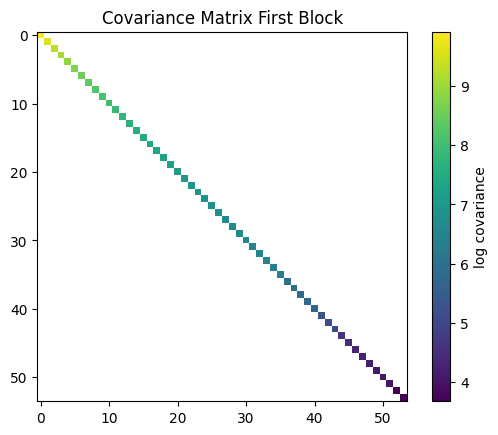

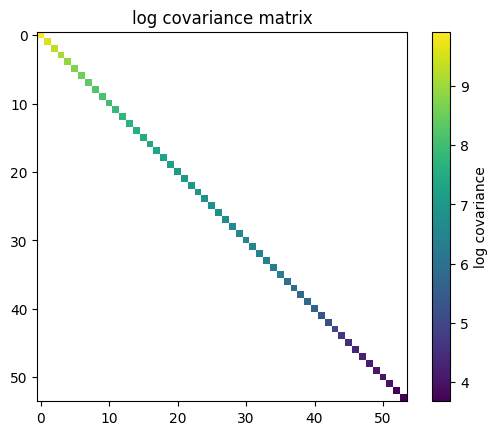

cov shape (54, 54)
bins, pairs: 1 * 54 = 54


'\nplt.imshow((cov_total_full), cmap=\'viridis\')#, vmin=vmin, vmax=vmax)\nplt.colorbar(label=\'covariance\')\nplt.title("covariance matrix")\nplt.show()\n\ndef cov2corr(cov):\n    stddev = np.sqrt(np.diag(cov))\n    corr = cov / np.outer(stddev, stddev)\n    np.fill_diagonal(corr, 1.0)\n    return corr\n\ncorr_matrix = np.corrcoef(cov_total_full)\nplt.imshow(np.log10(corr_matrix), cmap=\'viridis\')#, vmin=vmin, vmax=vmax)\nplt.colorbar(label=\'log correlation\')\nplt.title("log correlation_matrix")\nplt.show()\nplt.imshow((corr_matrix), cmap=\'viridis\')#, vmin=vmin, vmax=vmax)\nplt.colorbar(label=\'correlation\')\nplt.title("correlation_matrix")\nplt.show()\n'

In [19]:
C_b_fid = rebin([get_fg_model(centerfreqs, ells, fixed_par | var_par_fid)[s] for s in fore_indices])

freq_pairs = []
pair_index = {}
k = 0
for f1 in range(n_freq):
    for f2 in range(f1, n_freq):
        freq_pairs.append((f1, f2))
        pair_index[(f1, f2)] = k
        pair_index[(f2, f1)] = k
        k += 1
n_pairs = len(freq_pairs)
print(n_pairs)

#######################################################################################
#function that automatically adds only auto spectra noise for a given frequency pair
def sig_noise(f1, f2):
    C_total = sum(C_b_fid[s][f1, f2] for s in range(n_fore))
    if f1 == f2: #only if this term has an auto spectra include noise
        C_total += N_b[f1]
    return C_total

######################################################################################
#returns correct-looking covmat
cov_matrix = np.zeros((n_bins, n_pairs, n_pairs))
for a in range(n_freq):
    for b in range(n_freq):
        for c in range(n_freq):
            for d in range(n_freq):
                i = pair_index[(a, b)]
                j = pair_index[(c, d)]
                c_ac = sig_noise(a, c)
                c_bd = sig_noise(b, d)
                c_ad = sig_noise(a, d)
                c_bc = sig_noise(b, c)
                fsky_eff = (fsky[a]*fsky[b]*fsky[c]*fsky[d])**0.25
                for bin in range(n_bins):
                    cov_matrix[bin, i, j] = (1 / ((2*ell_bin+1)*(2*band)*fsky_eff)[bin]) * (c_ac[bin]*c_bd[bin] + c_ad[bin]*c_bc[bin])
                cov_matrix[:, j, i] = cov_matrix[:, i, j]
                #form cov_matrix[bin, fpair_1, fpair_2]
                
block = [[np.zeros((n_bins, n_bins)) for j in range(n_pairs)] for i in range(n_pairs)]

# Fill only the diagonal of each (n_bins × n_bins) block from cov_matrix
for i in range(n_pairs):
    for j in range(n_pairs):
        for b in range(n_bins):
            block[i][j][b, b] = cov_matrix[b, i, j]
  
blockshow = block[0][0]
plt.imshow(np.log10(blockshow), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='log covariance')
plt.title("Covariance Matrix First Block")
plt.show()

#arrange blocks into full matrix
cov_total_full = np.zeros((n_bins * n_pairs, n_bins * n_pairs))
for i in range(n_pairs):
    for j in range(n_pairs):
        #location in full matrix
        row_start = i * n_bins
        row_end = (i + 1) * n_bins
        col_start = j * n_bins
        col_end = (j + 1) * n_bins

        cov_total_full[row_start:row_end, col_start:col_end] = block[i][j]

#####################################################################

plt.imshow(np.log10(cov_total_full), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='log covariance')
plt.title("log covariance matrix")
plt.show()

print(f"cov shape {np.shape(cov_total_full)}")
print(f"bins, pairs: {n_pairs} * {n_bins} = {n_bins*n_pairs}")


# cov_total_full2 = np.diag(2*1/nu_b*(C_b[0][0,0] + N_b[0])**2)
                          
# plt.imshow(np.log10(blockshow-cov_total_full2), cmap='viridis')#, vmin=vmin, vmax=vmax)
# plt.colorbar(label='log covariance')
# plt.title("log covariance matrix")
# plt.show()
'''
plt.imshow((cov_total_full), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='covariance')
plt.title("covariance matrix")
plt.show()

def cov2corr(cov):
    stddev = np.sqrt(np.diag(cov))
    corr = cov / np.outer(stddev, stddev)
    np.fill_diagonal(corr, 1.0)
    return corr

corr_matrix = np.corrcoef(cov_total_full)
plt.imshow(np.log10(corr_matrix), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='log correlation')
plt.title("log correlation_matrix")
plt.show()
plt.imshow((corr_matrix), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='correlation')
plt.title("correlation_matrix")
plt.show()
'''

In [20]:
signal = np.zeros((n_bins, n_pairs))  # shape: (n_bins, n_pairs)
for s in range(n_fore):
    for i, (f1, f2) in enumerate(freq_pairs):
        signal[:, i] += C_b_fid[s][f1, f2]


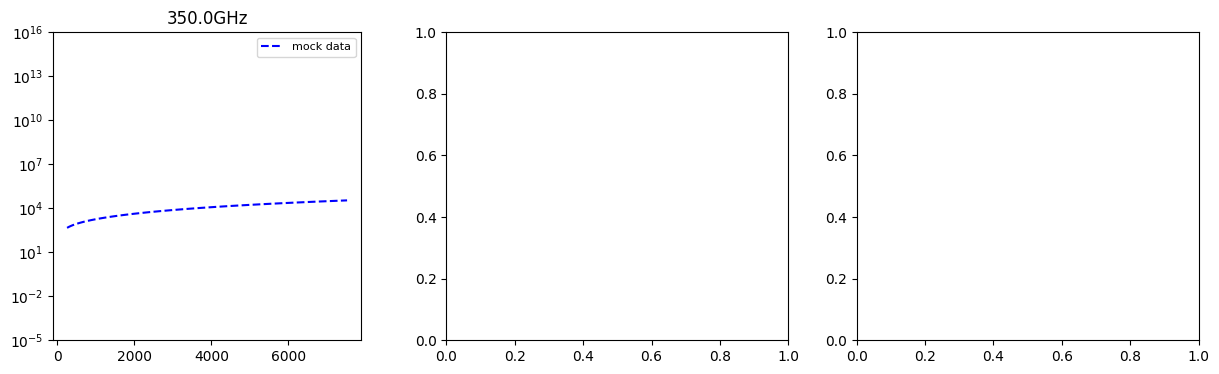

In [21]:
from matplotlib.animation import FuncAnimation, PillowWriter

ncols = 3
nrows = int(np.ceil(n_freq / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axs = axs.flatten()

# Initialize cumulative sum and count for running mean
running_sum = [np.zeros(n_bins) for _ in range(n_freq)]
running_count = [0 for _ in range(n_freq)]

def animate(j):
    #truths = np.array(var_par_truths)
    #var_par_noisy = truths + np.random.normal(loc=0.0, scale=1, size=truths.shape)
    #var_par = dict(zip(var_par_names, var_par_noisy))
    
    #thisfg = rebin(get_fg_model(centerfreqs, ells, fixed_par | var_par_fid))
    mock_data = signal.flatten()
    mock_data_2d = mock_data.reshape(n_bins, n_pairs)
    mock_autospectra = []

    for p in [pair_index[(f, f)] for f in range(n_freq)]:
        mock_autospectra.append(mock_data_2d[:, p])
    
    for f in range(n_freq):
        current_spec = mock_autospectra[f]
        running_sum[f] += current_spec
        running_count[f] += 1
        running_mean = running_sum[f] / running_count[f]

        ax = axs[f]
        ax.clear()

        sumfg = np.zeros(n_bins, dtype=np.float64)
        for s in range(n_fore):
            #ax.plot(ell_bin,C_b_fid[s][(f,f)], label=spectra_labels[s], color=dcolors[s])
            sumfg += C_b_fid[s][(f,f)]


        err = np.sqrt(2 / ((2*ell_bin+1)*(2*band)*fsky[f]))*(sumfg+N_b[f])
        
        #ax.errorbar(ell_bin,sumfg,err,fmt='o',markersize=1, color="lightblue")
        

        #ax.plot(ell_bin, N_b[f], label="D_l noise", linestyle='--', color='gray')

        
        ax.plot(ell_bin, mock_autospectra[f], label="mock data", linestyle='--', color='blue')
        #ax.plot(ell_bin, mock_autospectra[f]-1e10, label="mock data offset", linestyle='--', color='green')

        #ax.plot(ell_bin, sumfg, label="fg sum", linestyle='-', color='black')
        #ax.plot(ell_bin, running_mean, label="running mean", linestyle='-', color='purple')
        
        ax.legend(loc = 'upper right')
        ax.set_yscale('log')
        ax.set_ylim(10e-6, 10e15)
        ax.set_title(f"{centerfreqs[f]}GHz")
        ax.set_box_aspect(1)
        ax.legend(fontsize=8)

    return ()

ani = FuncAnimation(fig, animate, repeat=True, frames=5, interval=50)
# To save the animation using Pillow as a gif
writer = PillowWriter(fps=10,metadata=dict(artist='Me'),bitrate=1800)
ani.save('test.gif', writer=writer)


In [22]:

#add band centers to the label list
labels_with_freq = par_labels_fg + [rf"$\Delta\nu^{{{freq:.0f}}}_{{\mathrm{{band}}}}$" for freq in centerfreqs]
var_par_names = list(var_par_fid.keys())
var_par_truths = list(var_par_fid.values())
truths_with_freq = var_par_truths + [0]*n_freq

###################################################### GAUSS MCMC ###############################################
# Invert covariance matrix
cov_inv = np.linalg.inv(cov_total_full)
sign, logdet = np.linalg.slogdet(cov_total_full)

def log_likelihoodg(theta, data, cov_inv, logdet, offsets):
    fg_params = theta[:n_var]
    dnu_params = theta[n_var:]

    var_par = dict(zip(var_par_names, fg_params))
    shifted_freqs = centerfreqs + offsets + dnu_params
    C_b_shifted = rebin([get_fg_model(shifted_freqs, ells, fixed_par | var_par)[s] for s in fore_indices])

    model = np.zeros_like(data)
    for s in range(len(C_b_shifted)):
        T = np.zeros((n_bins, n_pairs))
        for idx, (f1, f2) in enumerate(freq_pairs):
            T[:, idx] = C_b_shifted[s][f1, f2]
        model += T.flatten()

    delta = data - model
    return -0.5 * (delta @ cov_inv @ delta)

def log_priorg(theta, mu_dnu, sigma_dnu):
    fg_params = theta[:n_var]
    dnu_params = theta[n_var:]

    for name, val in zip(var_par_names, fg_params):
        if name.startswith("a_") and (val < 0.0 or val > 20.0):
            return -np.inf
        if "beta" in name and (val < 0.0 or val > 10.0):
            return -np.inf
        if name == "xi" and (val < -2.0 or val > 10.0):
            return -np.inf

    gauss = -0.5 * np.sum(((dnu_params - mu_dnu) / sigma_dnu) ** 2)
    return gauss

def log_probabilityg(theta, data, cov_inv, logdet, offsets, mu_dnu, sigma_dnu):
    lp = log_priorg(theta, mu_dnu, sigma_dnu)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihoodg(theta, data, cov_inv, logdet, offsets)

def run_emcee_gauss(offsets=np.zeros(n_freq), mu_array=np.zeros(n_freq), sigma_array=np.ones(n_freq), plot=True):

    mock_data = signal.flatten()

    ndim = n_var + n_freq
    nwalkers = 128

    initial = np.hstack([np.array(var_par_truths) + 0.01 * np.random.randn(nwalkers, n_var),
                         mu_array + 0.01 * np.random.randn(nwalkers, n_freq)])

    with Pool(processes=8) as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probabilityg,
            args=(mock_data, cov_inv, logdet, offsets, mu_array, sigma_array),
            pool=pool
        )
        sampler.run_mcmc(initial, 5000, progress=True) 

    samples = sampler.get_chain(discard=500, thin=1, flat=True)
    if plot:
        #trace plots
        chains = sampler.get_chain()
        n_steps, n_walkers, ndim = chains.shape

        fig, axes = plt.subplots(ndim, 1, figsize=(10, 2.5 * ndim), sharex=True)

        for i in range(ndim):
            ax = axes[i]
            for walker in range(n_walkers):
                ax.plot(chains[:, walker, i], alpha=0.5, lw=0.5)
            ax.set_ylabel(labels_with_freq[i])
            ax.axhline(truths_with_freq[i], color='r', linestyle='--', label=labels_with_freq[i])
            ax.legend(loc='upper right')

        plt.suptitle("MCMC Trace Plots", fontsize=16)
        plt.tight_layout()
        plt.show()
    return samples


In [23]:
n_runs = 1
small_sigma = np.ones(n_freq) * 0.001
#offset = fts_res(ccat_freqs,1000) #np.concatenate((fts_res(ccat_freqs,1000),[0.8,-1,1.5]), axis=0)

1


100%|██████████| 5000/5000 [18:37<00:00,  4.47it/s]


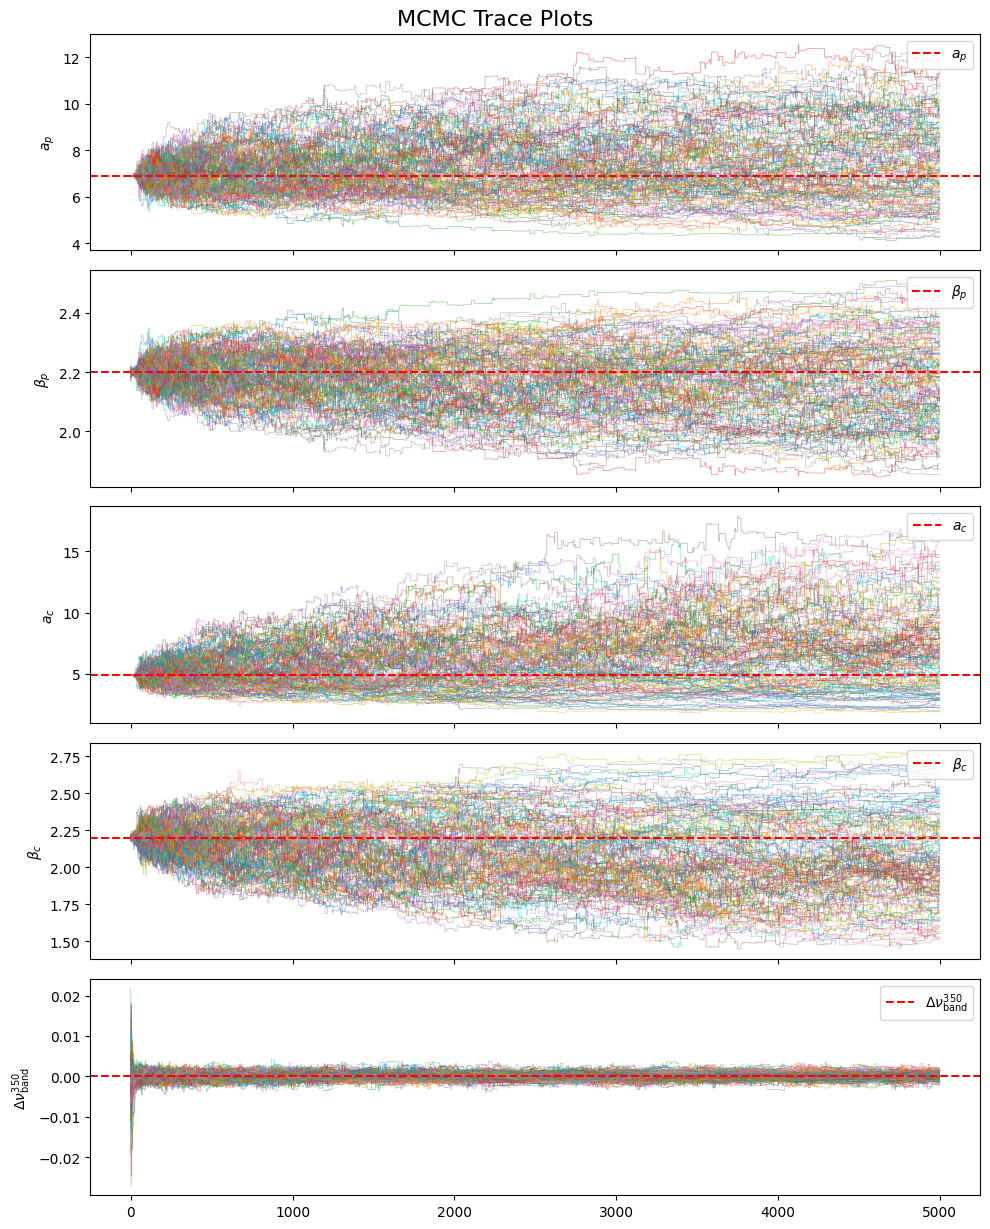

In [24]:
samples_fid = []
for i in range(n_runs):
    print(i+1)
    s = run_emcee_gauss(
        offsets=np.zeros(n_freq),
        mu_array=np.zeros(n_freq),
        sigma_array=small_sigma,
        plot=True
    )
    samples_fid.append(s)


In [25]:
np.shape(samples_fid)

(1, 576000, 5)

Text(0.5, 1.02, 'CCAT:[350.]GHz')

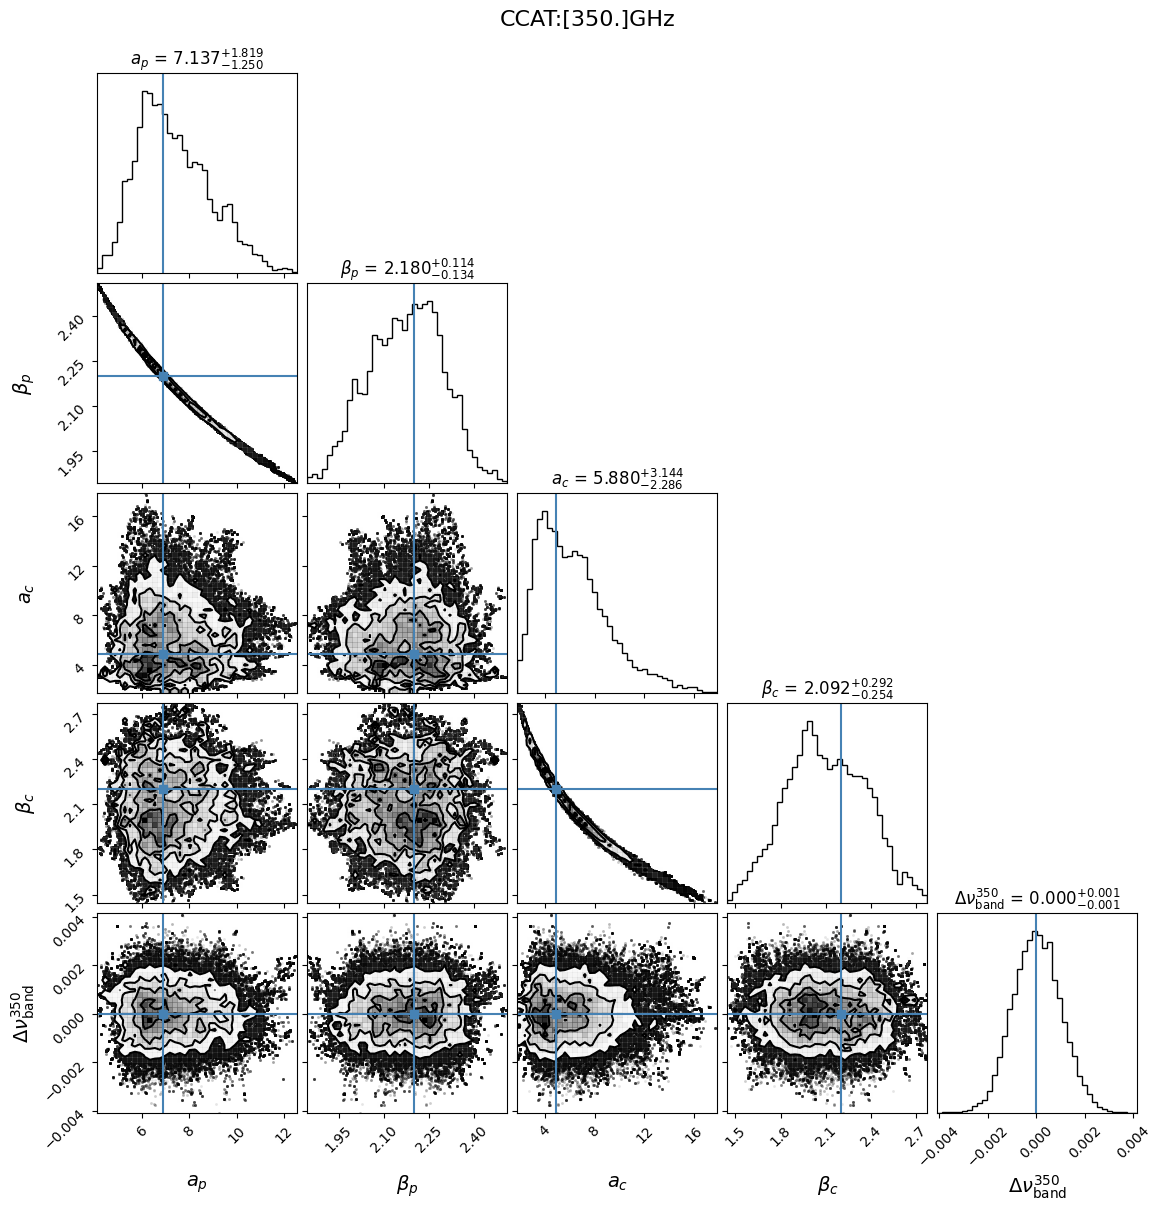

In [26]:

corner.corner(
    samples_fid[0],           
    labels=labels_with_freq,           
    truths=truths_with_freq,            
    label_kwargs={"fontsize": 14},
    show_titles=True,
    title_fmt=".3f",
    title_kwargs={"fontsize": 12},
    bins=40,
)
plt.suptitle(f"CCAT:{centerfreqs}GHz", fontsize=16, y=1.02)

In [27]:
means_fid = np.median(np.vstack(samples_fid), axis=0)
stds_fid = np.std(np.vstack(samples_fid), axis=0)

{'a_p': 6.9, 'beta_p': 2.2, 'a_c': 4.9, 'beta_c': 2.2}
{'a_p': 7.1368318635816115, 'beta_p': 2.180289863232653, 'a_c': 5.879737372769959, 'beta_c': 2.0915282835799873}


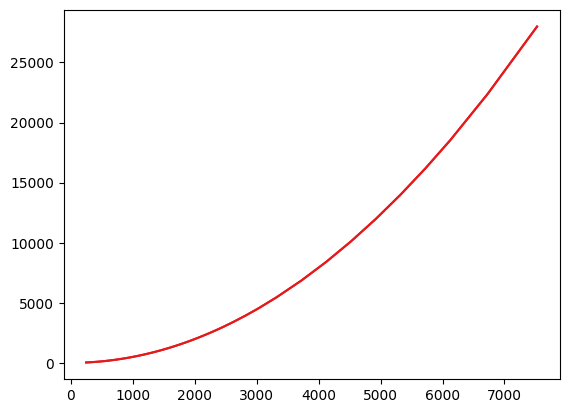

In [28]:
print(var_par_fid)
var_par_found = dict(zip(var_par_names, means_fid))
print(var_par_found)

C_b_fid = rebin([get_fg_model(centerfreqs, ells, fixed_par | var_par_fid)[s] for s in fore_indices])

C_b_found = rebin([get_fg_model(centerfreqs, ells, fixed_par | var_par_found)[s] for s in fore_indices])

for s in [0]:
    plt.plot(ell_bin,C_b_fid[s][(0,0)], label=spectra_labels[s], color=dcolors[s])
    plt.plot(ell_bin,C_b_found[s][(0,0)], label=spectra_labels[s], color=dcolors[s])
    #plt.ylim(1.4e10,1.6e10)
    #plt.xlim(4000,4010)

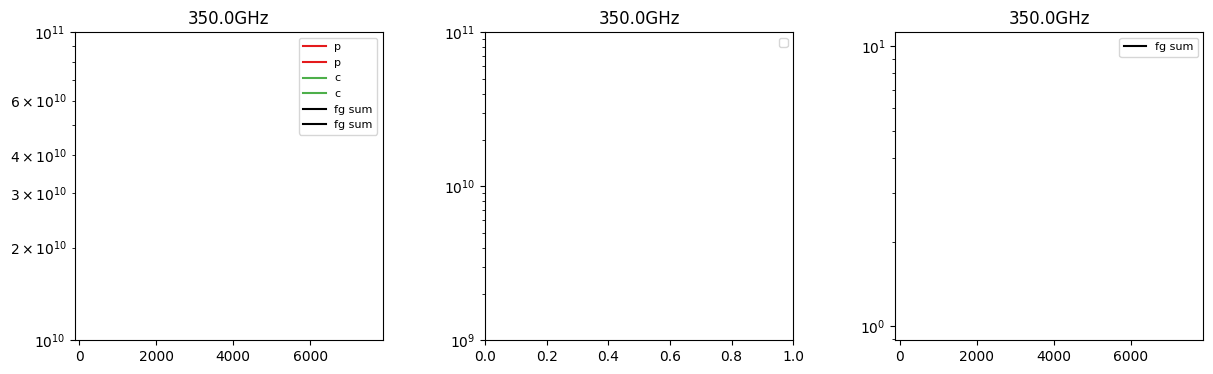

In [29]:
ncols = 3
nrows = int(np.ceil(n_freq / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axs = axs.flatten()


sumfg0 = np.zeros(n_bins, dtype=np.float64)
sumfg1 = np.zeros(n_bins, dtype=np.float64)
for s in range(n_fore):
    axs[0].plot(ell_bin,C_b_fid[s][(0,0)], label=spectra_labels[s], color=dcolors[s])
    axs[0].plot(ell_bin,C_b_found[s][(0,0)], label=spectra_labels[s], color=dcolors[s])

    sumfg0 += C_b_fid[s][(0,0)]
    sumfg1 += C_b_found[s][(0,0)]

err0 = np.sqrt(2 / ((2*ell_bin+1)*(2*band)*fsky[0]))*(sumfg0+N_b[0])
err1 = np.sqrt(2 / ((2*ell_bin+1)*(2*band)*fsky[0]))*(sumfg1+N_b[0])
axs[0].errorbar(ell_bin,sumfg0,err0,fmt='o',markersize=1, color="lightblue")
axs[0].plot(ell_bin, sumfg0, label="fg sum", linestyle='-', color='black')
axs[0].errorbar(ell_bin,sumfg1,err1,fmt='o',markersize=1, color="lightblue")
axs[0].plot(ell_bin, sumfg1, label="fg sum", linestyle='-', color='black')

axs[2].plot(ell_bin, sumfg1-sumfg0, label="fg sum", linestyle='-', color='black')

axs[0].legend(loc = 'upper right')
axs[0].set_yscale('log')
axs[0].set_ylim(10e9, 10e10)
axs[0].set_title(f"{centerfreqs[0]}GHz")
axs[0].set_box_aspect(1)
axs[0].legend(fontsize=8)
axs[1].legend(loc = 'upper right')
axs[1].set_yscale('log')
axs[1].set_ylim(10e8, 10e10)
axs[1].set_title(f"{centerfreqs[0]}GHz")
axs[1].set_box_aspect(1)
axs[1].legend(fontsize=8)
axs[2].legend(loc = 'upper right')
axs[2].set_yscale('log')
#axs[2].set_ylim(10e-6, 10e15)
axs[2].set_title(f"{centerfreqs[0]}GHz")
axs[2].set_box_aspect(1)
axs[2].legend(fontsize=8)


[7.13683186e+00 2.18028986e+00 5.87973737e+00 2.09152828e+00
 3.54221678e-05]


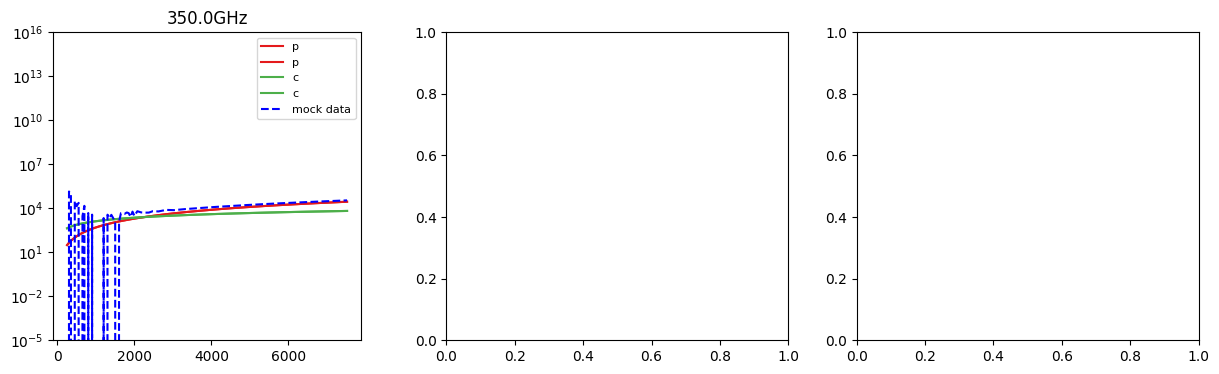

In [30]:
from matplotlib.animation import FuncAnimation, PillowWriter

ncols = 3
nrows = int(np.ceil(n_freq / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axs = axs.flatten()

# Initialize cumulative sum and count for running mean
running_sum = [np.zeros(n_bins) for _ in range(n_freq)]
running_count = [0 for _ in range(n_freq)]

C_b_found = rebin(get_fg_model(centerfreqs, ells, fixed_par | var_par_found))
def animate(j):
    #truths = np.array(var_par_truths)
    #var_par_noisy = truths + np.random.normal(loc=0.0, scale=1, size=truths.shape)
    #var_par = dict(zip(var_par_names, var_par_noisy))
    
    mock_data = np.random.multivariate_normal(mean=signal.flatten(), cov=cov_total_full)
    mock_data_2d = mock_data.reshape(n_bins, n_pairs)
    mock_autospectra = []

    for p in [pair_index[(f, f)] for f in range(n_freq)]:
        mock_autospectra.append(mock_data_2d[:, p])
    
    for f in range(n_freq):
        current_spec = mock_autospectra[f]
        running_sum[f] += current_spec
        running_count[f] += 1
        running_mean = running_sum[f] / running_count[f]

        ax = axs[f]
        ax.clear()

        sumfg = np.zeros(n_bins, dtype=np.float64)
        for s in range(n_fore):
            ax.plot(ell_bin,C_b_fid[s][(f,f)], label=spectra_labels[s], color=dcolors[s])
            ax.plot(ell_bin,C_b_fid[s][(f,f)], label=spectra_labels[s], color=dcolors[s])

            sumfg += C_b_fid[s][(f,f)]


        err = np.sqrt(2 / ((2*ell_bin+1)*(2*band)*fsky[f]))*(sumfg+N_b[f])
        
        #ax.errorbar(ell_bin,sumfg,err,fmt='o',markersize=1, color="lightblue")
        

        #ax.plot(ell_bin, N_b[f], label="D_l noise", linestyle='--', color='gray')

        
        ax.plot(ell_bin, mock_autospectra[f], label="mock data", linestyle='--', color='blue')
        #ax.plot(ell_bin, mock_autospectra[f]-1e10, label="mock data offset", linestyle='--', color='green')

        #ax.plot(ell_bin, sumfg, label="fg sum", linestyle='-', color='black')
        #ax.plot(ell_bin, running_mean, label="running mean", linestyle='-', color='purple')
        
        ax.legend(loc = 'upper right')
        ax.set_yscale('log')
        ax.set_ylim(10e-6, 10e15)
        ax.set_title(f"{centerfreqs[f]}GHz")
        ax.set_box_aspect(1)
        ax.legend(fontsize=8)

    return ()

ani = FuncAnimation(fig, animate, repeat=True, frames=5, interval=50)
# To save the animation using Pillow as a gif
writer = PillowWriter(fps=10,metadata=dict(artist='Me'),bitrate=1800)
ani.save('test.gif', writer=writer)
print(means_fid)